In [ ]:
# importing required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from decimal import Decimal

In [ ]:
# downloading the data
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))])),
            batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))])),
            batch_size=batch_size_test, shuffle=True)


Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw


Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw


Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw


Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# defining the dropout module
class MyDropout(nn.Module):
    def __init__(self, p):
        self.p = p
        self.previous_pattern=False
        super().__init__()

    def forward(self, x):
        if not self.p:
            return x
        # p is non-zero at this point
        if not self.training and not self.previous_pattern:
                return x
        # at this point, either (train time) or (test time, previous_pattern)
        x = x.clone()
        if self.training:
            mask = x.new_empty(1, x.size(1), requires_grad = False).bernoulli_(1-self.p)
            mask = mask.div_(1-self.p)
            self.mask = mask.clone()
        else: # test time, previous_pattern
            mask = self.mask.clone()
            # print("only %d neurons are active!"%(torch.sum((mask>0).int())))
        mask = mask.expand_as(x)
        return x * mask

In [ ]:
# defining the network
class Net(nn.Module):
    def __init__(self, width, p):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, width)
        self.dropout = MyDropout(p)
        self.fc2 = nn.Linear(width, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
# the training function
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if (epoch==1 and batch_idx in test_log_intervals) or (batch_idx and batch_idx % log_interval == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        if (epoch==1 and batch_idx in test_log_intervals) or (batch_idx and batch_idx % test_log_interval == 0):
            test_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            test()
            test(previous_pattern=True)
        network.train()
    test_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    test()
    test(previous_pattern=True)
    if  run == 0 and width in [500, 5000, 50000, 250000] and learning_rate == 0.01 and drop_rate == 0.5:
        model_name = './results/models/model_lr=%f_rate=%f_width=%d_run=%d.pt'%(learning_rate, drop_rate, width, run)
        optim_name = './results/optims/optim_lr=%f_rate=%f_width=%d_run=%d.pt'%(learning_rate, drop_rate, width, run)
        torch.save(network.state_dict(), model_name)
        torch.save(optimizer.state_dict(), optim_name)

# the test function
def test(previous_pattern=False):
    network.eval()
    network.dropout.previous_pattern = previous_pattern
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    if previous_pattern:
        test_sparse_losses.append(test_loss)
        test_sparse_acc.append(acc)
        print('\nTest sparse set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), acc))
    else:
        test_losses.append(test_loss)
        test_acc.append(acc)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), acc))
    network.dropout.previous_pattern = False


In [ ]:
# cuda?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# initializing parameters
lrs = [0.01]
drop_rates = [0.3]
widths = [10000]
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
momentum = 0.0
log_interval = 25
test_log_interval = 200
test_log_intervals = [1, 10, 25, 50, 100, 150, 200, 300, 500]

# main loop
runs = [0]
run = runs[0]
random_seed = run + 1

In [ ]:
for learning_rate in lrs:
    for drop_rate in drop_rates:
        for width in widths:
            torch.manual_seed(random_seed)
            if not os.path.exists('./results/stats/'):
                os.makedirs('./results/stats/')            
            print('run = %d, width = %d, rate = %f, lr = %f'%(run, width, drop_rate, learning_rate))
            file_name = './results/stats/stats_lr=%f_rate=%f_width=%d_run=%d.pt'%(learning_rate, drop_rate, width, run)
            if os.path.isfile(file_name):
                print('%s already exists'%file_name)
                continue
            
            train_losses, test_losses, test_acc, test_sparse_losses, test_sparse_acc, train_counter, test_counter = [], [], [], [], [], [], []

            network = Net(width, drop_rate)
            network.to(device)
            optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

            for epoch in range(1, n_epochs + 1):
              train(epoch)

            torch.save({'train_counter': train_counter,
                        'test_counter': test_counter,
                        'test_sparse_losses': test_sparse_losses,
                        'test_sparse_acc': test_sparse_acc,
                        'test_losses': test_losses,
                        'test_acc': test_acc,
                        'train_losses': train_losses}, file_name)



run = 0, width = 10000, rate = 0.300000, lr = 0.010000
./results/stats/stats_lr=0.010000_rate=0.300000_width=10000_run=0.pt already exists


In [ ]:
results_dir = os.listdir('./results/stats')
first_file = results_dir[0]
first_dict = torch.load('./results/stats/%s'%first_file, map_location=torch.device('cpu'))
train_counter = first_dict['train_counter']
test_counter = first_dict['test_counter']
first_dict.keys()

dict_keys(['train_counter', 'test_counter', 'test_sparse_losses', 'test_sparse_acc', 'test_losses', 'test_acc', 'train_losses'])

In [ ]:
train_loss  = np.zeros([len(runs), len(lrs), len(drop_rates), len(widths), len(train_counter)])
test_loss   = np.zeros([len(runs), len(lrs), len(drop_rates), len(widths), len(test_counter)])
test_acc    = np.zeros([len(runs), len(lrs), len(drop_rates), len(widths), len(test_counter)])
sparse_loss = np.zeros([len(runs), len(lrs), len(drop_rates), len(widths), len(test_counter)])
sparse_acc  = np.zeros([len(runs), len(lrs), len(drop_rates), len(widths), len(test_counter)])

In [ ]:
for r_idx, r in enumerate(runs):
    for lr_idx, lr in enumerate(lrs):
        for p_idx, p in enumerate(drop_rates):
            for w_idx, w in enumerate(widths):
                file_name = 'stats_lr=%f_rate=%f_width=%d_run=%d.pt'%(lr, p, w, r)
                if file_name in results_dir:
                    results_dict = torch.load('./results/stats/%s'%file_name, map_location=torch.device('cpu'))
                    train_loss[r_idx, lr_idx, p_idx, w_idx, :] = results_dict['train_losses']
                    test_loss[r_idx, lr_idx, p_idx, w_idx, :] = results_dict['test_losses']
                    test_acc[r_idx, lr_idx, p_idx, w_idx, :] = results_dict['test_acc']
                    sparse_loss[r_idx, lr_idx, p_idx, w_idx, :] = results_dict['test_sparse_losses']
                    sparse_acc[r_idx, lr_idx, p_idx, w_idx, :] = results_dict['test_sparse_acc']
                else:
                    print('bad lr=%f_rate=%f_width=%d_run=%d'%(lr, p, w, r))
                    train_loss[r_idx, lr_idx, p_idx, w_idx, :] = np.array([np.nan]*len(train_counter))
                    test_loss[r_idx, lr_idx, p_idx, w_idx, :] = np.array([np.nan]*len(test_counter))
                    test_acc[r_idx, lr_idx, p_idx, w_idx, :] = np.array([np.nan]*len(test_counter))
                    sparse_loss[r_idx, lr_idx, p_idx, w_idx, :] = np.array([np.nan]*len(test_counter)) 
                    sparse_acc[r_idx, lr_idx, p_idx, w_idx, :] = np.array([np.nan]*len(test_counter)) 

In [ ]:
train_loss_mean = np.nanmin(train_loss, axis=0)
train_loss_std = np.nanstd(train_loss, axis=0)

test_loss_mean = np.nanmin(test_loss, axis=0)
test_loss_std = np.nanstd(test_loss, axis=0)

test_acc_mean = np.nanmin(test_acc, axis=0)
test_acc_std = np.nanstd(test_acc, axis=0)

sparse_loss_mean = np.nanmin(sparse_loss, axis=0)
sparse_loss_std = np.nanstd(sparse_loss, axis=0)

sparse_acc_mean = np.nanmin(sparse_acc, axis=0)
sparse_acc_std = np.nanstd(sparse_acc, axis=0)

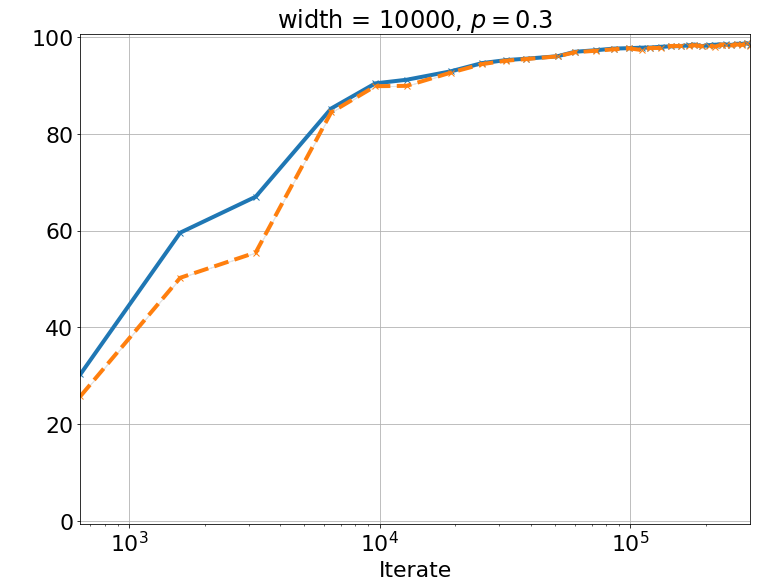

In [ ]:
cutoff = 1
for lr_idx, lr in enumerate(lrs):
    for p_idx, p in enumerate(drop_rates):
        for w_idx, w in enumerate(widths):

            curr_test = test_acc_mean[lr_idx, p_idx, w_idx, cutoff:]
            curr_test_std = test_acc_std[lr_idx, p_idx, w_idx, cutoff:]

            curr_sparse = sparse_acc_mean[lr_idx, p_idx, w_idx, cutoff:]
            curr_sparse_std = sparse_acc_std[lr_idx, p_idx, w_idx, cutoff:]

#             plot_name = './plots/acc_iter_lr=%f_rate=%f_width=%d.pdf'%(lr, p, w)
            plot_name = './plots/acc_iter_rate=%.E_width=%d.pdf'%(Decimal(p), w)
            if not os.path.exists('./plots/'):
                os.makedirs('./plots/')            

            plt.close()
            plt.figure(figsize=(12,9))

            plt.plot(test_counter[cutoff:], curr_test, marker='x', linewidth=4, label=r"full network $f(\cdot; \mathrm{W}_t)$")
            plt.fill_between(test_counter[cutoff:], curr_test-curr_test_std, curr_test+curr_test_std, color='gray', alpha=0.2)

            plt.plot(test_counter[cutoff:], curr_sparse, marker='x', linewidth=4, linestyle='dashed', label=r"sub-network $g(\mathrm{W}_t; \cdot, \mathrm{B}_t)$")
            plt.fill_between(test_counter[cutoff:], curr_sparse-curr_sparse_std, curr_sparse+curr_sparse_std, color='gray', alpha=0.2)

            ax = plt.gca()
            ax.tick_params(axis = 'both', which = 'major', labelsize = 22)
            # plt.xticks(np.arange(d[0])+1) 
            plt.xlim((test_counter[cutoff],test_counter[-1]))
            plt.ylim((-.5,100.5))
            if (p==0.5 and w==100) or (p==0.1 and w==250000):
                plt.ylabel('Test Accuracy', fontsize=22)
            else:
                plt.ylabel(' ', fontsize=22)
            if (p==0.1 and w==250000):
                plt.legend(prop={'size': 26})
            plt.xlabel('Iterate', fontsize=22)
            plt.title(r'width = %d, $p = %.1f$'%(w, p), fontsize=24)
            # plt.yscale('log')
            plt.xscale('log')
            plt.grid()
            plt.savefig(plot_name, bbox_inches='tight')
            plt.show()